🧩 Task 1 → Fidelity: 1.000000


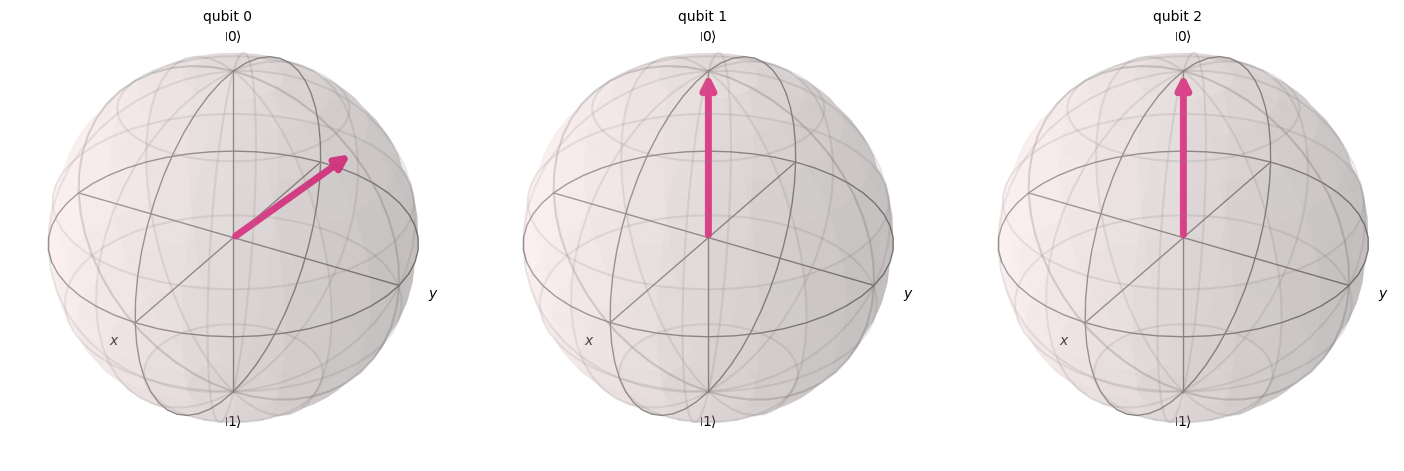

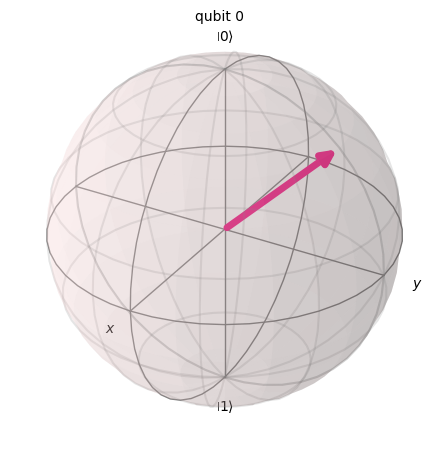

In [10]:
!pip install qiskit qiskit_aer pylatexenc --quiet

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

# ------------------------------------------------------
# 🧩 Task 1: Custom State Teleportation
# ------------------------------------------------------

def teleport_state(theta, phi, noise_model=None, measure=False):
    """Perform coherent or measured teleportation for given theta, phi."""
    qc = QuantumCircuit(3, 2 if measure else 0)

    # Step 1: Prepare arbitrary state |ψ> on qubit 0
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv_init = Statevector.from_instruction(qc)

    # Step 2: Create Bell pair between qubits 1 and 2
    qc.h(1)
    qc.cx(1, 2)

    # Step 3: Bell measurement
    qc.cx(0, 1)
    qc.h(0)

    if measure:
        qc.measure(0, 0)
        qc.measure(1, 1)
        # Conditional corrections
        qc.x(2).c_if(0, 1)
        qc.z(2).c_if(1, 1)
        qc.x(2).c_if(1, 1)
        qc.z(2).c_if(0, 1)

    else:
        # Coherent corrections (no measurement)
        qc.cx(1, 2)
        qc.cz(0, 2)
        qc.save_statevector()

    # Simulate
    sim = AerSimulator(noise_model=noise_model)
    job = sim.run(transpile(qc, sim))
    result = job.result()

    # Extract final statevector (for coherent version)
    if not measure:
        sv_final = Statevector(result.data(0)["statevector"])
        rho_bob = partial_trace(sv_final, [0, 1])
    else:
        sv_final = None
        rho_bob = None

    # Compute fidelity (only coherent version)
    if not measure:
        rho_init = partial_trace(sv_init, [1, 2])
        eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
        eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
        bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
        init_state = eigvecs_i[:, np.argmax(eigvals_i)]
        fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
    else:
        fidelity = None

    return sv_init, rho_bob, fidelity, qc

theta, phi = math.pi / 4, math.pi / 2
sv_init, rho_bob, fidelity, qc = teleport_state(theta, phi)
print(f"🧩 Task 1 → Fidelity: {fidelity:.6f}")

# Visualize the initial state
display(plot_bloch_multivector(sv_init))

# ✅ Fix: Extract Bob’s pure eigenvector before plotting
eigvals, eigvecs = np.linalg.eigh(rho_bob.data)
bob_state = eigvecs[:, np.argmax(eigvals)]  # Dominant eigenvector
bob_sv = Statevector(bob_state)

# Visualize Bob’s final qubit (teleported state)
display(plot_bloch_multivector(bob_sv))


In [20]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity, partial_trace
import numpy as np

def teleport_state(theta, phi, measure=False):

    # Initial State |ψ⟩
    init_state = Statevector([
        np.cos(theta/2),
        np.exp(1j * phi) * np.sin(theta/2)
    ])

    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(2, "c")
    qc = QuantumCircuit(qr, cr)

    qc.initialize(init_state, 0)

    # Create entanglement (Bell pair)
    qc.h(1)
    qc.cx(1, 2)

    # Bell measurement
    qc.cx(0, 1)
    qc.h(0)

    if measure:
        qc.measure(0, 0)
        qc.measure(1, 1)

        # Conditional: X for 01
        qc.x(2)
        qc.data[-1].operation.condition = (cr, 1)

        # Conditional: Z for 10
        qc.z(2)
        qc.data[-1].operation.condition = (cr, 2)

        # Conditional: Z for 11
        qc.z(2)
        qc.data[-1].operation.condition = (cr, 3)

        final_state = Statevector.from_instruction(qc)
        rho_bob = final_state.to_density_matrix().ptrace(2)
        fidelity = state_fidelity(rho_bob, init_state)

    else:
        qc.cx(1, 2)
        qc.cz(0, 2)
        qc.save_statevector()

        # Simulate to get the statevector
        sim = AerSimulator()
        job = sim.run(transpile(qc, sim))
        result = job.result()
        final_statevector = Statevector(result.data(0)["statevector"])

        # Calculate Bob's reduced density matrix
        rho_bob = partial_trace(final_statevector, [0, 1])

        # Calculate fidelity
        # Get the initial state as a density matrix for fidelity calculation
        rho_init = init_state.to_density_matrix()
        fidelity = state_fidelity(rho_bob, rho_init)


    return init_state, rho_bob, fidelity, qc

theta = np.pi/3
phi = np.pi/4

print("\n🔍 Task 5 → Introducing Noise Model")

# --- Define noise model ---
noise_model = NoiseModel()

# 1-qubit depolarizing noise (for ry, rz, h)
error_1q = depolarizing_error(0.01, 1)

# 2-qubit depolarizing noise (for cx)
error_2q = depolarizing_error(0.02, 2)

# amplitude damping (1-qubit only)
error_amp = amplitude_damping_error(0.02)

# Add noise to 1-qubit gates
noise_model.add_all_qubit_quantum_error(error_1q, ['ry', 'rz', 'h'])
noise_model.add_all_qubit_quantum_error(error_amp, ['ry', 'rz'])

# Add noise to 2-qubit gates
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])


# --- Run noisy teleportation ---
fidelities_noisy = []

for _ in tqdm(range(N)):
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2*np.pi)

    sv_init, rho_bob, fidelity, qc = teleport_state(theta, phi)
    fidelities_noisy.append(fidelity)

avg_fid_noisy = np.mean(fidelities_noisy)
print(f"\n✅ Average fidelity under noise: {avg_fid_noisy:.6f}")


# --- Plot fidelity ---
plt.figure(figsize=(7,4))
plt.plot(range(1, N+1), fidelities_noisy, 'o-', label="Noisy Fidelity")
plt.axhline(y=avg_fid_noisy, linestyle='--', label=f"Avg = {avg_fid_noisy:.4f}")
plt.xlabel("Trial")
plt.ylabel("Fidelity")
plt.title("Teleportation Fidelity under Noise")
plt.legend()
plt.show()



📈 Task 3 → Fidelity Analysis for multiple random states


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]



Average fidelity over 15 random states: 1.000000


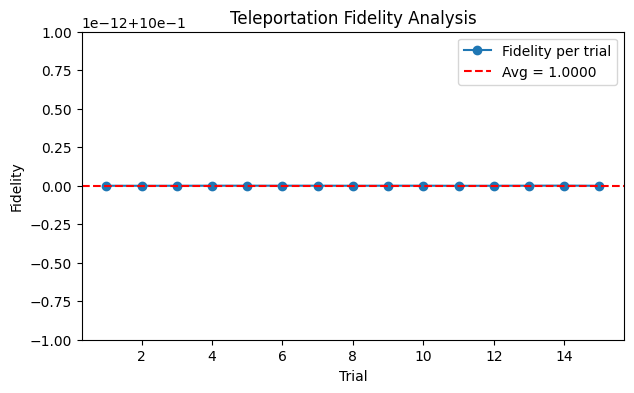

In [ ]:

print("\n📈 Task 3 → Fidelity Analysis for multiple random states")

N = 15
fidelities = []
angles = []

for _ in tqdm(range(N)):
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2*np.pi)
    sv_init, rho_bob, fidelity, qc = teleport_state(theta, phi)
    fidelities.append(fidelity)
    angles.append((theta, phi))

avg_fidelity = np.mean(fidelities)
print(f"\nAverage fidelity over {N} random states: {avg_fidelity:.6f}")

plt.figure(figsize=(7,4))
plt.plot(range(1, N+1), fidelities, 'o-', label="Fidelity per trial")
plt.axhline(y=avg_fidelity, color='r', linestyle='--', label=f"Avg = {avg_fidelity:.4f}")
plt.xlabel("Trial")
plt.ylabel("Fidelity")
plt.title("Teleportation Fidelity Analysis")
plt.legend()
plt.show()


🎨 Task 4 → Step-by-Step Bloch Visualization


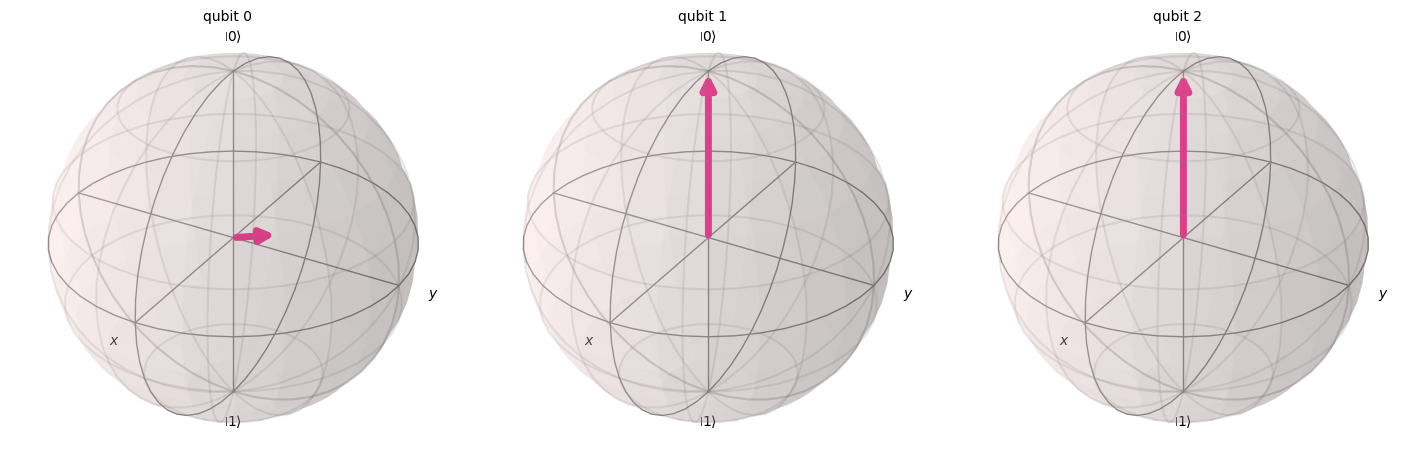

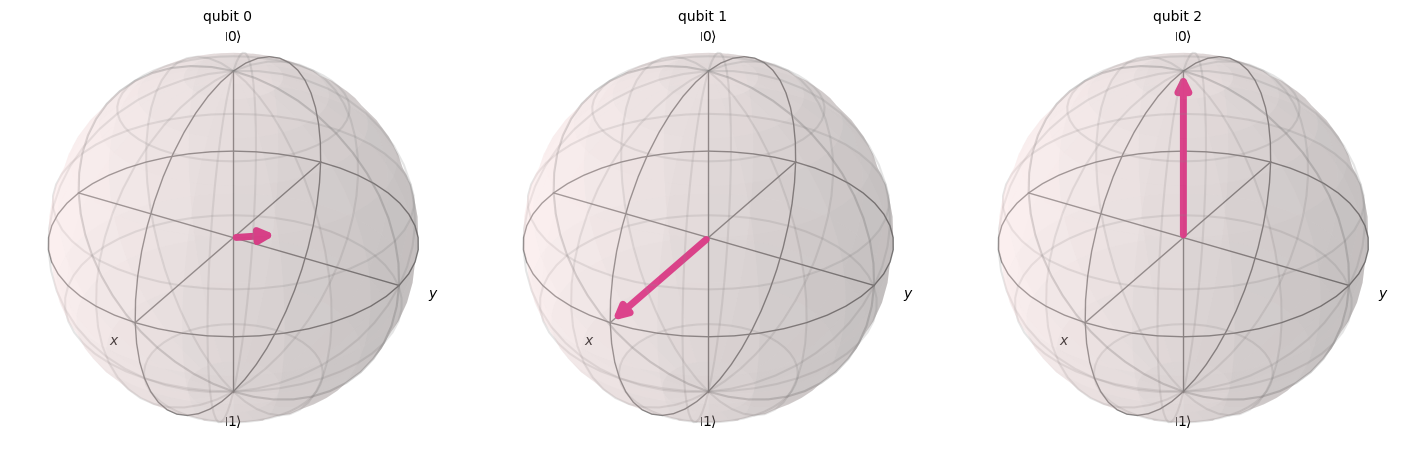

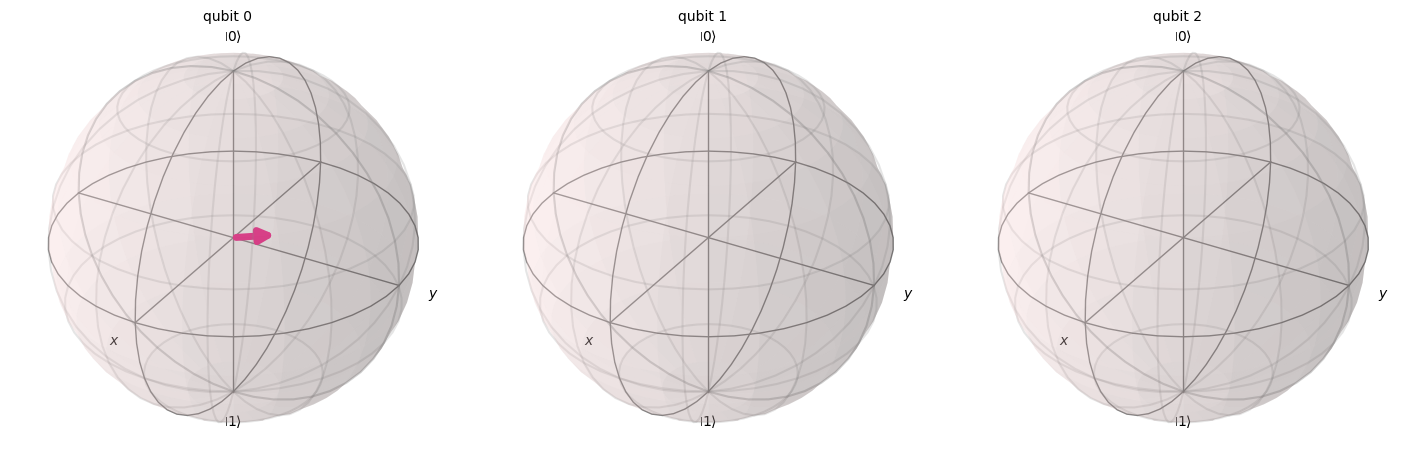

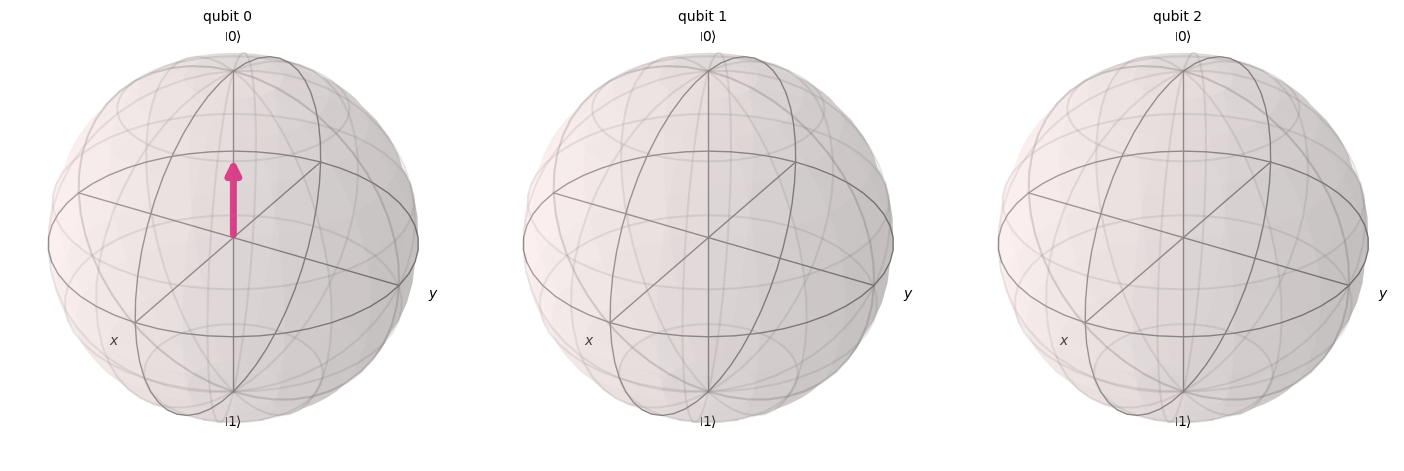

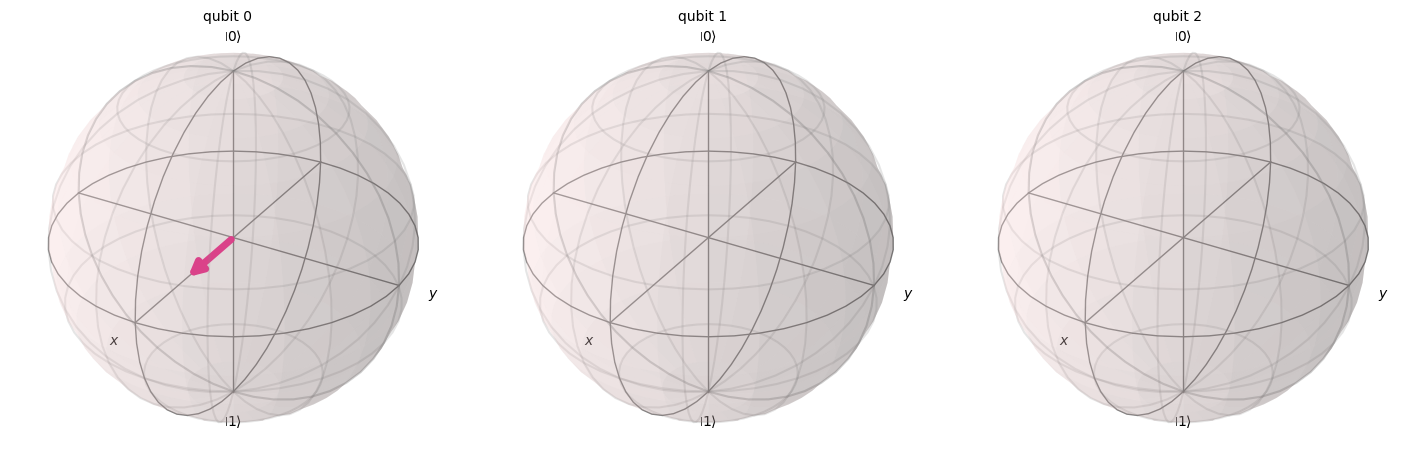

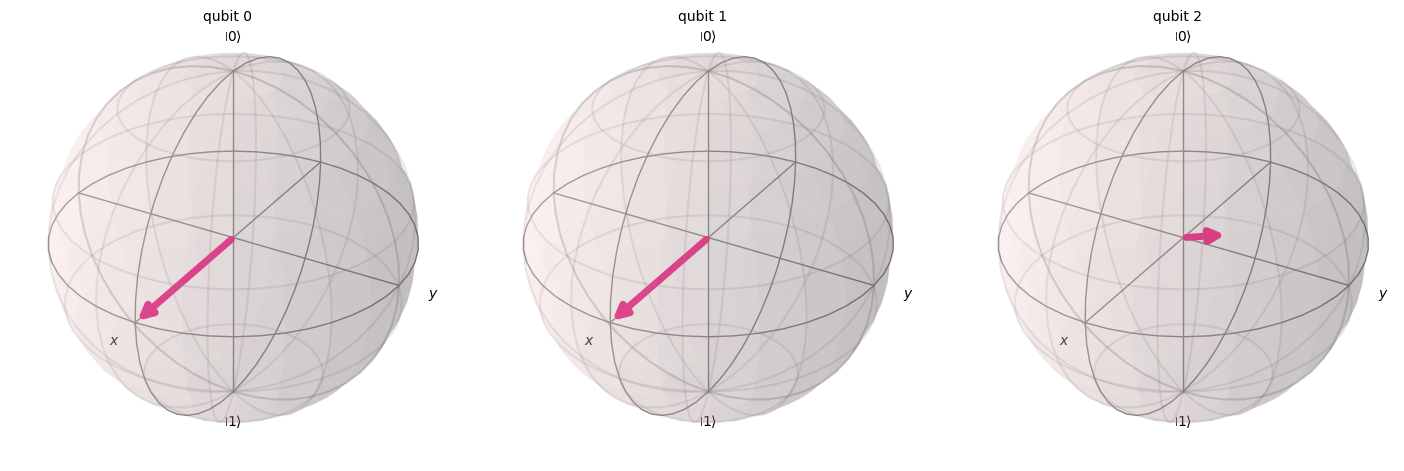

✅ Step-by-step visualizations complete.


In [ ]:

# ------------------------------------------------------
# 🎨 Task 4: Step-by-Step Visualization
# ------------------------------------------------------

print("\n🎨 Task 4 → Step-by-Step Bloch Visualization")

qc_step = QuantumCircuit(3)
theta, phi = np.pi/3, np.pi/4
qc_step.ry(theta, 0)
qc_step.rz(phi, 0)

# Step 0: initial
sv = Statevector.from_instruction(qc_step)
display(plot_bloch_multivector(sv))

# After H on qubit 1
qc_step.h(1)
sv = Statevector.from_instruction(qc_step)
display(plot_bloch_multivector(sv))

# After CX(1,2)
qc_step.cx(1, 2)
sv = Statevector.from_instruction(qc_step)
display(plot_bloch_multivector(sv))

# After CX(0,1)
qc_step.cx(0, 1)
sv = Statevector.from_instruction(qc_step)
display(plot_bloch_multivector(sv))

# After H(0)
qc_step.h(0)
sv = Statevector.from_instruction(qc_step)
display(plot_bloch_multivector(sv))

# After final corrections
qc_step.cx(1, 2)
qc_step.cz(0, 2)
sv = Statevector.from_instruction(qc_step)
display(plot_bloch_multivector(sv))

print("✅ Step-by-step visualizations complete.")

In [19]:
print("\n🔍 Task 5 → Introducing Noise Model")

# --- Define noise model ---
noise_model = NoiseModel()

# 1-qubit depolarizing noise (for ry, rz, h)
error_1q = depolarizing_error(0.01, 1)

# 2-qubit depolarizing noise (for cx)
error_2q = depolarizing_error(0.02, 2)

# amplitude damping (1-qubit only)
error_amp = amplitude_damping_error(0.02)

# Add noise to 1-qubit gates
noise_model.add_all_qubit_quantum_error(error_1q, ['ry', 'rz', 'h'])
noise_model.add_all_qubit_quantum_error(error_amp, ['ry', 'rz'])

# Add noise to 2-qubit gates
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])


# --- Run noisy teleportation ---
fidelities_noisy = []

for _ in tqdm(range(N)):
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2*np.pi)

    sv_init, rho_bob, fidelity, qc = teleport_state(theta, phi)
    fidelities_noisy.append(fidelity)

avg_fid_noisy = np.mean(fidelities_noisy)
print(f"\n✅ Average fidelity under noise: {avg_fid_noisy:.6f}")


# --- Plot fidelity ---
plt.figure(figsize=(7,4))
plt.plot(range(1, N+1), fidelities_noisy, 'o-', label="Noisy Fidelity")
plt.axhline(y=avg_fid_noisy, linestyle='--', label=f"Avg = {avg_fid_noisy:.4f}")
plt.xlabel("Trial")
plt.ylabel("Fidelity")
plt.title("Teleportation Fidelity under Noise")
plt.legend()
plt.show()



🔍 Task 5 → Introducing Noise Model


  0%|          | 0/15 [00:00<?, ?it/s]


AttributeError: 'Statevector' object has no attribute 'to_density_matrix'